In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
%matplotlib inline

Для любой модели из курса(кроме KNN) и данных на которых она строилась: применить метод главных компонент к данным и сравнить работу модели на исходных данных с работой на данных, где в качестве признаков используются две главные компоненты.

In [2]:
class LogisticRegression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = n_iterations
        self.eta = eta

    def _log_grad(self, X, target):
        m = X.shape[0]
        y = (2 * target - 1)
        score = np.dot(X, self.w.T).flatten() + self.w0
        Z = -y / (m * (1 + np.exp(y * score)))
        grad = Z[np.newaxis, :].dot(X)
        return grad / m, np.sum(Z) / m

    def _optimize(self, X, target):
        for i in range(self.n_iterations):
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w -= self.eta * grad_w
            self.w0 -= self.eta * grad_w0

    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0 = 0
        self._optimize(X, target)

    def predict_proba(self, X):
        score = X.dot(self.w.T).flatten() + self.w0
        return 1 / (1 + np.exp(-score))

    def predict(self, X, thr=0.5, exact_proba=False):
        """
        При exact_proba=True возвращает значения вероятности целевой 
        переменной без отнесения к классу
        """
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=np.int8)
        y_predicted[proba > thr] = 1
        y_predicted[proba <= thr] = 0
        return y_predicted if not exact_proba else proba

    @staticmethod
    def _confusion(y_predicted, y_actual):
        """
        :param y_predicted: predicted target value
        :param y_actual: real target value
        :return: tuple of following true positive, false positive,
                 true negative and false negative
        """
        TP = np.sum(np.logical_and(y_predicted == 1, y_actual == 1))
        FP = np.sum(np.logical_and(y_predicted == 1, y_actual == 0))
        TN = np.sum(np.logical_and(y_predicted == 0, y_actual == 0))
        FN = np.sum(np.logical_and(y_predicted == 0, y_actual == 1))
        return TP, FP, TN, FN

    def metrics(self, y_predicted, y_actual, metric='tpr_fpr'):
        """
        Возвращает значение требуемой метрики (f1, tpr_fpr, pr_rec)
        """
        TP, FP, TN, FN = self._confusion(y_predicted, y_actual)
        if TP or FP:
            precision = TP / (TP + FP)
        else:
            precision = 0
        if TP or FN:
            recall = TP / (TP + FN)
        else:
            recall = 0
        if precision or recall:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        TPR = recall
        FPR = FP / (FP + TN)
        if metric == 'tpr_fpr':
            return TPR, FPR
        elif metric == 'f1':
            return f1
        elif metric == 'pr_rec':
            return precision, recall
        else:
            print('wrong metric id used')
            return None

Сгенерируем датасет из 100 наблюдений и 4х признаков

In [3]:
X, y = make_classification(n_samples=100,
                                    n_features=4,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_classes=2,
                                    random_state=56)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=2, shuffle=True)

In [4]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

In [5]:
y_pred = log_reg_model.predict(X_train)
print(f'f1-метрика на трейне: {log_reg_model.metrics(y_pred, y_train, metric="f1")}')

f1-метрика на трейне: 0.8656716417910447


In [6]:
y_pred = log_reg_model.predict(X_test)
print(f'f1-метрика на тесте: {log_reg_model.metrics(y_pred, y_test, metric="f1")}')

f1-метрика на тесте: 0.8387096774193549


Применим метод PCA

In [7]:
X_train_norm = X_train.astype(float)
# Сохраним значение среднего и стд для последующих преобразований
mean = np.apply_along_axis(np.mean, 0, X_train_norm)
std = np.apply_along_axis(np.std, 0, X_train_norm)

X_train_norm -= np.mean(X_train_norm, axis=0)
X_train_norm /= np.std(X_train_norm, axis=0)

In [8]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_train_norm.T.dot(X_train_norm)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения: собственный вектор в порядке убывания:')
for i in eig_pairs:
    print(f'{i[0]}: {i[1]}')

Собственные значения: собственный вектор в порядке убывания:
77.96414534687045: [-0.40707333 -0.34641881 -0.3106734   0.78598178]
74.62967016338443: [-0.54762306 -0.30045524  0.77306519 -0.11048005]
67.07003245718333: [-0.55971859  0.82448092 -0.06947526  0.04603806]
48.336152032561785: [-0.47022908 -0.33158991 -0.54865786 -0.60655363]


In [9]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[29.09109901002629, 27.846891852009115, 25.02613151387438, 18.03587762409022]
Кумулятивная доля дисперсии по компонентам 
[ 29.09109901  56.93799086  81.96412238 100.        ]


Оценим вклад в общую дисперсию каждой из компонент

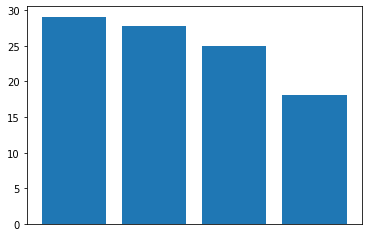

In [10]:
plt.bar(range(len(var_exp)), var_exp)
plt.xticks([], []);

В этом случае снижение размерности с 4х до 2х приведет к значительным потерям информации. Посмотрим, как это отразится на поведениии модели

In [11]:
# Посчитаем, сколько дисперсии мы потеряем 
sum(var_exp[-2:])

43.062009137964594

In [12]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[-0.40707333 -0.54762306]
 [-0.34641881 -0.30045524]
 [-0.3106734   0.77306519]
 [ 0.78598178 -0.11048005]]


Получим новую матрицу признаков для тренировочной и тестовой выборок

In [13]:
X_train_pca = X_train_norm.dot(W)

In [14]:
X_test_norm = (X_test - mean[np.newaxis, :]) / std[np.newaxis, :]
X_test_pca = X_test_norm.dot(W)

Обучим модель на вновь сформированных данных сниженной размерности

In [15]:
log_reg_model.fit(X_train_pca, y_train)

In [16]:
y_pred = log_reg_model.predict(X_train_pca)
print(f'f1-метрика на трейне: {log_reg_model.metrics(y_pred, y_train, metric="f1")}')

f1-метрика на трейне: 0.704225352112676


In [17]:
y_pred = log_reg_model.predict(X_test_pca)
print(f'f1-метрика на тесте: {log_reg_model.metrics(y_pred, y_test, metric="f1")}')

f1-метрика на тесте: 0.6666666666666666


Видим, что точность модели серьезно снизилась

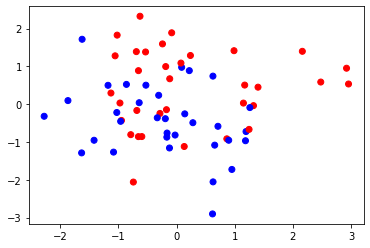

In [18]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=ListedColormap(['red', 'blue']));

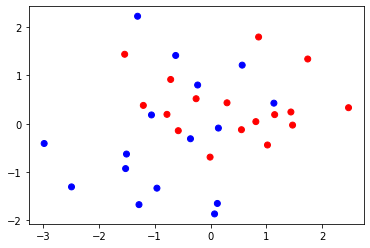

In [19]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=ListedColormap(['red', 'blue']));